# Торговая система на основе комбинации PSAR, фракталов и ATR: оптимизация и тестирование на криптовалютном рынке
### **Лямин А.Д.** | Анализ финансовых рынков (Технический анализ) | Факультет экономических наук, НИУ ВШЭ
### Исходный код стратегии: [Репозиторий GitHub](https://github.com/lyaminartemiy/hse-crypto-strategy-psar-fractals) 

В работе представлена разработка и эмпирическая оценка торговой системы, использующей комбинацию трех технических индикаторов: параболического SAR (PSAR), фракталов Билла Вильямса и среднего истинного диапазона (ATR). Система реализована на языке `Python` с использованием библиотек для финансового анализа. Оптимизация параметров проводилась на периоде с января 2022 по декабрь 2024 года с применением фреймворка `Optuna`. Тестирование осуществлялось на независимом периоде с января 2025 года.

Для анализа использовались дневные данные по Bitcoin (BTC-USD) за период с 1 января 2022 года по 10 июля 2025 года. Данные получены через `API Yahoo Finance`. Общий объем выборки составляет 1287 торговых дней. Выбор криптовалюты в качестве базового актива обусловлен:
- Высокой ликвидностью рынка
- Непрерывностью торгов (24/7)
- Отсутствием дивидендных выплат, упрощающим анализ

In [1]:
import sys

sys.path.append("..")

In [2]:
from matplotlib import pyplot as plt

from src import (
    Config,
    DataLoader,
    TradingStrategy,
    ParameterOptimizer,
    PerformanceMetrics,
    StrategyVisualizer,
)

In [3]:
# Загрузка данных
loader = DataLoader(Config.TICKER)
data = loader.get_data()

Загрузка данных для BTC-USD...


[*********************100%***********************]  1 of 1 completed

Данные загружены: 1462 дней (2021-12-02 - 2025-12-02)
Разделение данных:
   Train: 1096 дней (2022-01-01 - 2024-12-31)
   Test:  336 дней (2025-01-01 - 2025-12-02)


# Индикаторы

### **Parabolic SAR (PSAR)**

Параболический SAR разработан Дж. Уэллсом Уайлдером-младшим. Индикатор генерирует точки (Stop and Reverse), расположенные ниже цены при восходящем тренде и выше цены при нисходящем. Формально, значение PSAR на момент $t$ вычисляется как:

\begin{equation}
SAR_t = SAR_{t-1} + AF \times (EP - SAR_{t-1})
\end{equation}

где $AF$ — фактор ускорения (начальное значение 0.02, увеличивается на 0.02 при каждом новом экстремуме до максимума 0.20), $EP$ — экстремальная цена (максимум для бычьего тренда, минимум для медвежьего).

### **Фракталы Билла Вильямса**

Фракталы идентифицируют локальные максимумы и минимумы на основе паттерна из пяти свечей. Для фрактала максимума:

\begin{equation}
\begin{aligned}
&High_t > High_{t-2} \\
&High_t > High_{t-1} \\
&High_t > High_{t+1} \\
&High_t > High_{t+2}
\end{aligned}
\end{equation}

Аналогично для фрактала минимума:

\begin{equation}
\begin{aligned}
&Low_t < Low_{t-2} \\
&Low_t < Low_{t-1} \\
&Low_t < Low_{t+1} \\
&Low_t < Low_{t+2}
\end{aligned}
\end{equation}

### **Average True Range (ATR)**

ATR измеряет волатильность рынка, учитывая гэпы между свечами. Истинный диапазон (True Range) определяется как:

\begin{equation}
TR_t = \max(High_t - Low_t, |High_t - Close_{t-1}|, |Low_t - Close_{t-1}|)
\end{equation}

ATR представляет собой скользящее среднее TR за период $N$:

\begin{equation}
ATR_t = \frac{1}{N}\sum_{i=t-N+1}^{t} TR_i
\end{equation}

# Стратегия

Система работает по следующим правилам:

- Вход в позицию (`Long`):
\begin{equation}
(Close_t > PSAR_t) and (ATR_t > SMA(ATR, M)_t) and (Close_t > FractalLow_{t-1})
\end{equation}

- Выход из позиции:

\begin{equation}
Close_t < PSAR_t or has FractalHigh_t
\end{equation}

где $SMA(ATR, M)$ — простое скользящее среднее ATR за период $M$.

# Оптимизация

Для оптимизации параметров использовался фреймворк `Optuna`.

Целевая функция — максимизация коэффициента Шарпа, рассчитываемого как:

\begin{equation}
Sharpe = \frac{\bar{R} \times \sqrt{252}}{\sigma_R}
\end{equation}

где $\bar{R}$ — средняя дневная доходность, $\sigma_R$ — стандартное отклонение дневной доходности.

Период оптимизации: 1 января 2022 — 31 декабря 2024 (756 торговых дней). Проведено 50 итераций оптимизации.

In [4]:
optimizer = ParameterOptimizer(data["train"])
best_params = optimizer.optimize(n_trials=30, show_progress=True)

[I 2025-12-03 02:26:18,123] A new study created in memory with name: no-name-7d2bac3b-41b3-4f11-ac92-5179fba5b1c9


Оптимизация параметров стратегии...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-03 02:26:18,160] Trial 0 finished with value: 1.4730784796020764 and parameters: {'psar_af': 0.01749080237694725, 'psar_max': 0.2901428612819832, 'atr_period': 18, 'atr_sma_period': 24}. Best is trial 0 with value: 1.4730784796020764.
[I 2025-12-03 02:26:18,179] Trial 1 finished with value: 0.8983135142352795 and parameters: {'psar_af': 0.01312037280884873, 'psar_max': 0.13119890406724052, 'atr_period': 10, 'atr_sma_period': 28}. Best is trial 0 with value: 1.4730784796020764.
[I 2025-12-03 02:26:18,200] Trial 2 finished with value: 0.9719427441714489 and parameters: {'psar_af': 0.022022300234864175, 'psar_max': 0.2416145155592091, 'atr_period': 10, 'atr_sma_period': 30}. Best is trial 0 with value: 1.4730784796020764.
[I 2025-12-03 02:26:18,217] Trial 3 finished with value: 1.2821625842417494 and parameters: {'psar_af': 0.026648852816008435, 'psar_max': 0.14246782213565523, 'atr_period': 12, 'atr_sma_period': 17}. Best is trial 0 with value: 1.4730784796020764.
[I 2025-12-0

Наилучшая комбинация параметров достигла коэффициента Шарпа 1.9198 на периоде оптимизации.

In [5]:
# Стратегия с оптимальными параметрами
strategy = TradingStrategy(best_params)
results, trades = strategy.run(data)

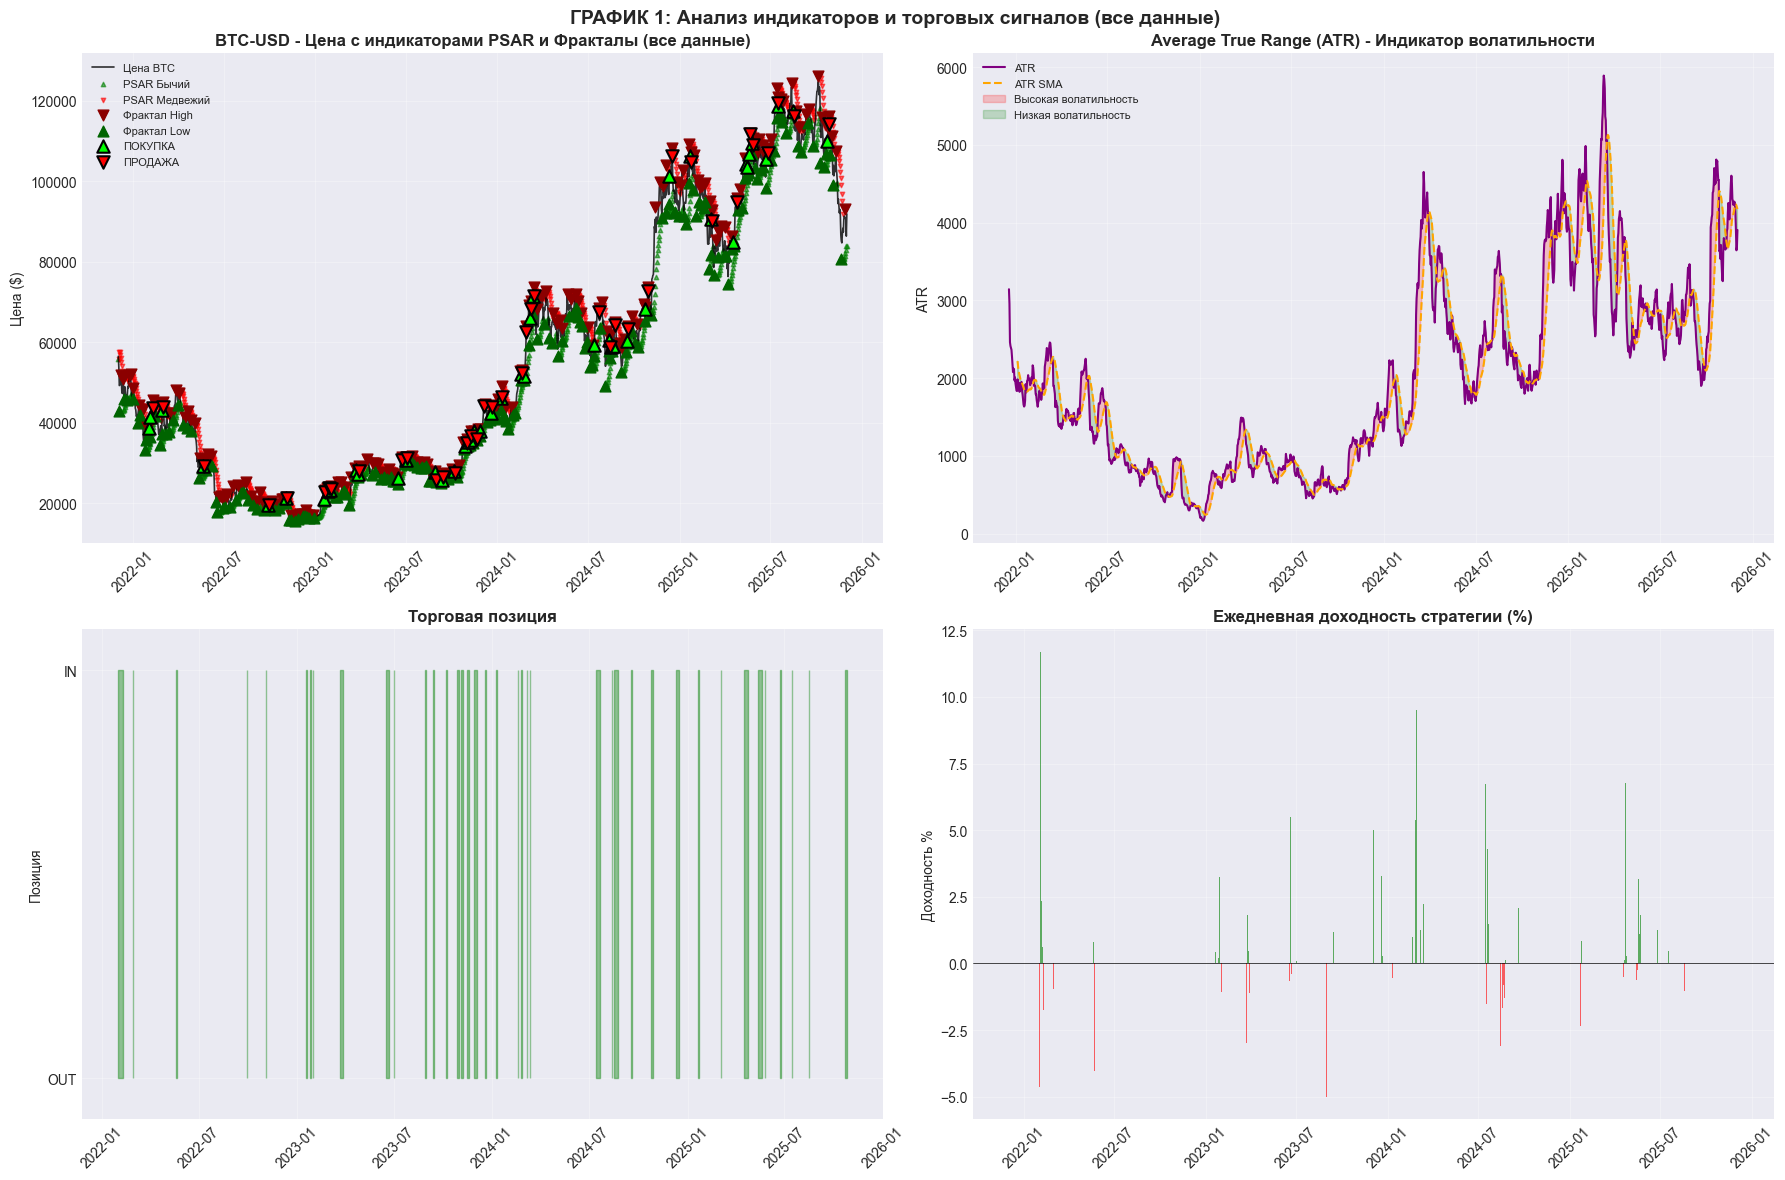

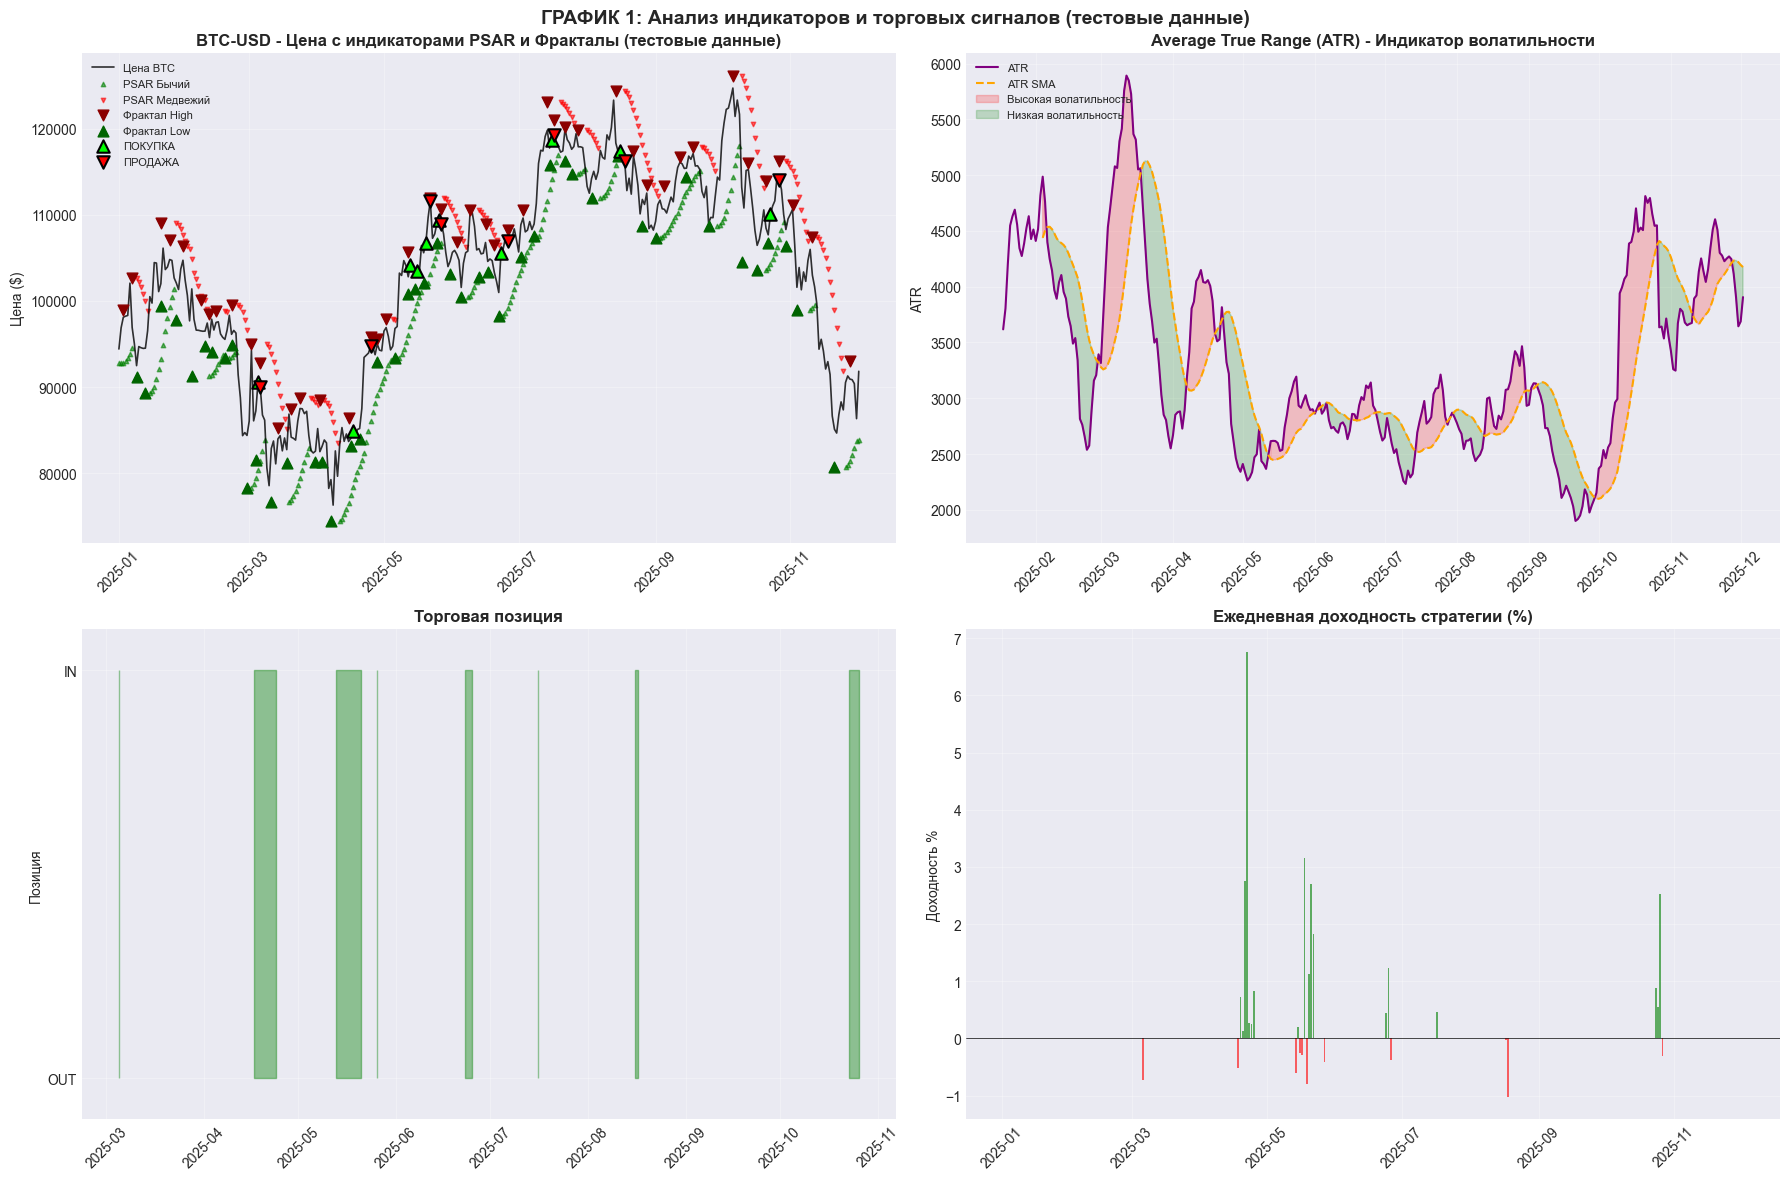

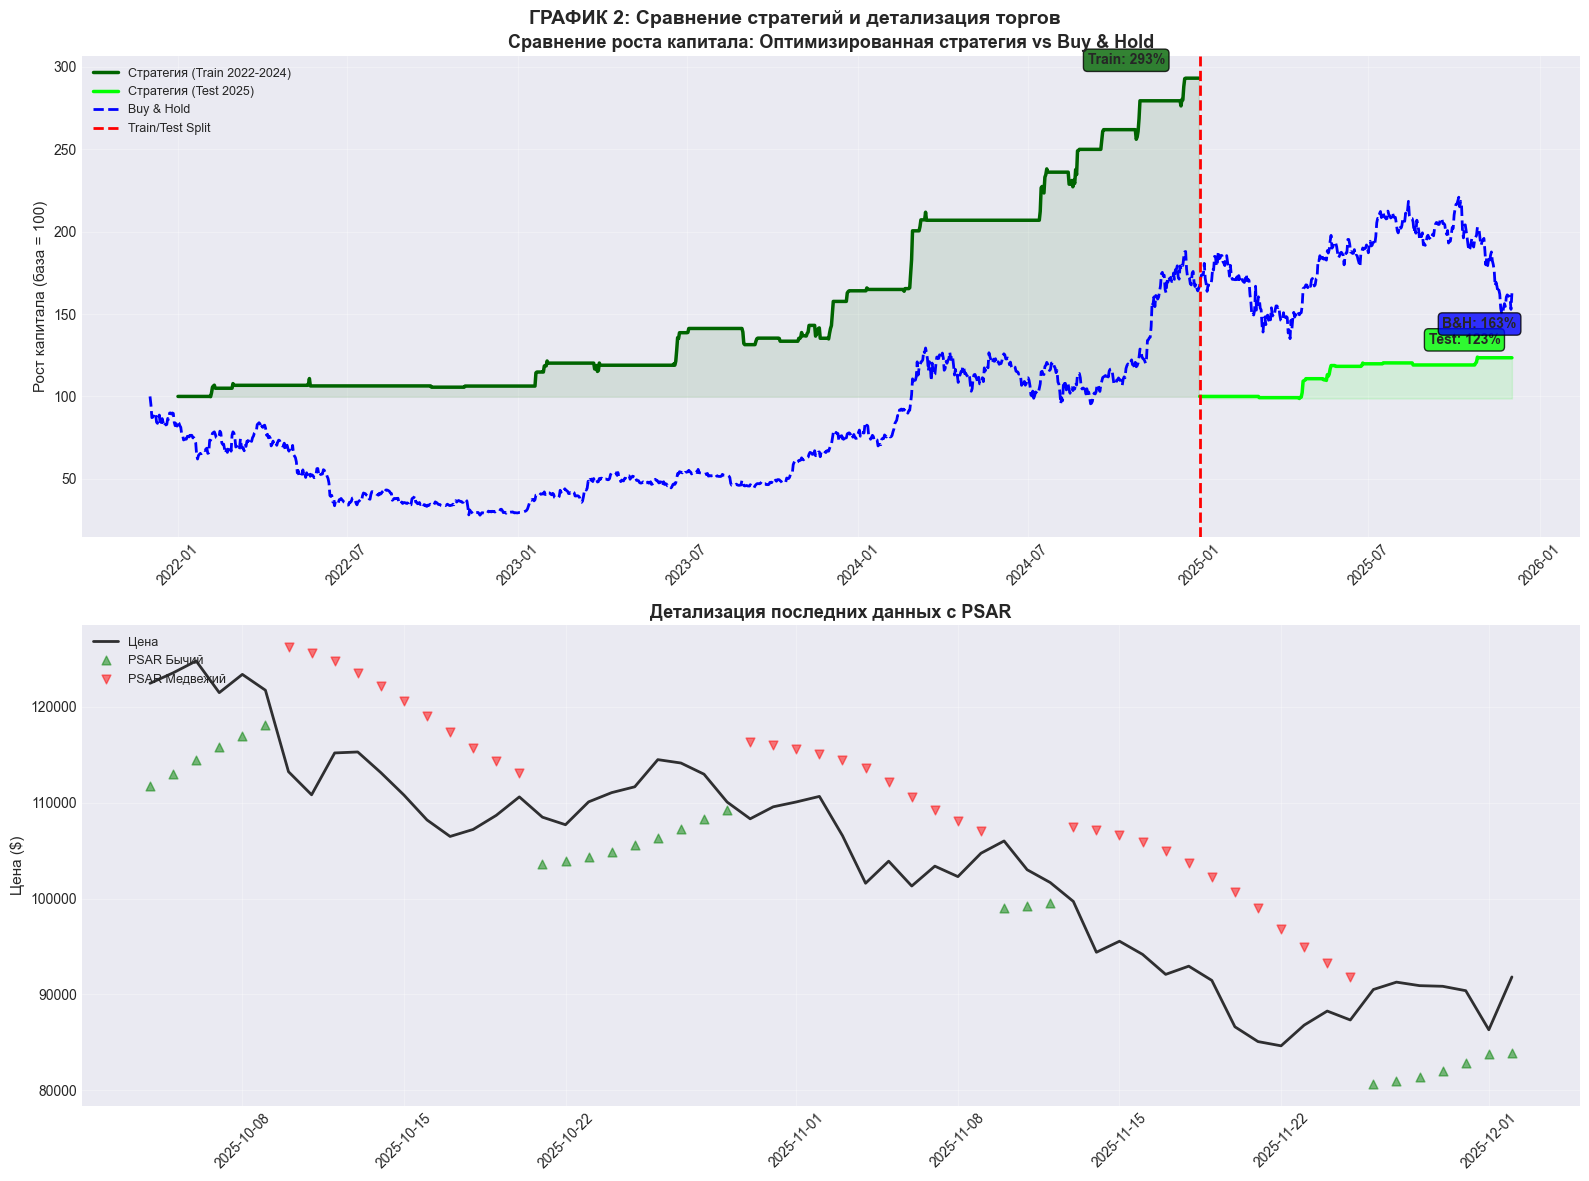

In [6]:
# Визуализация
visualizer = StrategyVisualizer()

# График 1 для полных данных
fig1 = visualizer.plot_indicators_and_signals(results["full"], "(все данные)")
plt.show()

# График 1 для тестовых данных
fig2 = visualizer.plot_indicators_and_signals(results["test"], "(тестовые данные)")
plt.show()

fig = visualizer.plot_strategy_comparison(
    results["train"], results["test"], results["full"], Config.TEST_START
)
plt.show()

## Метрики стратегии

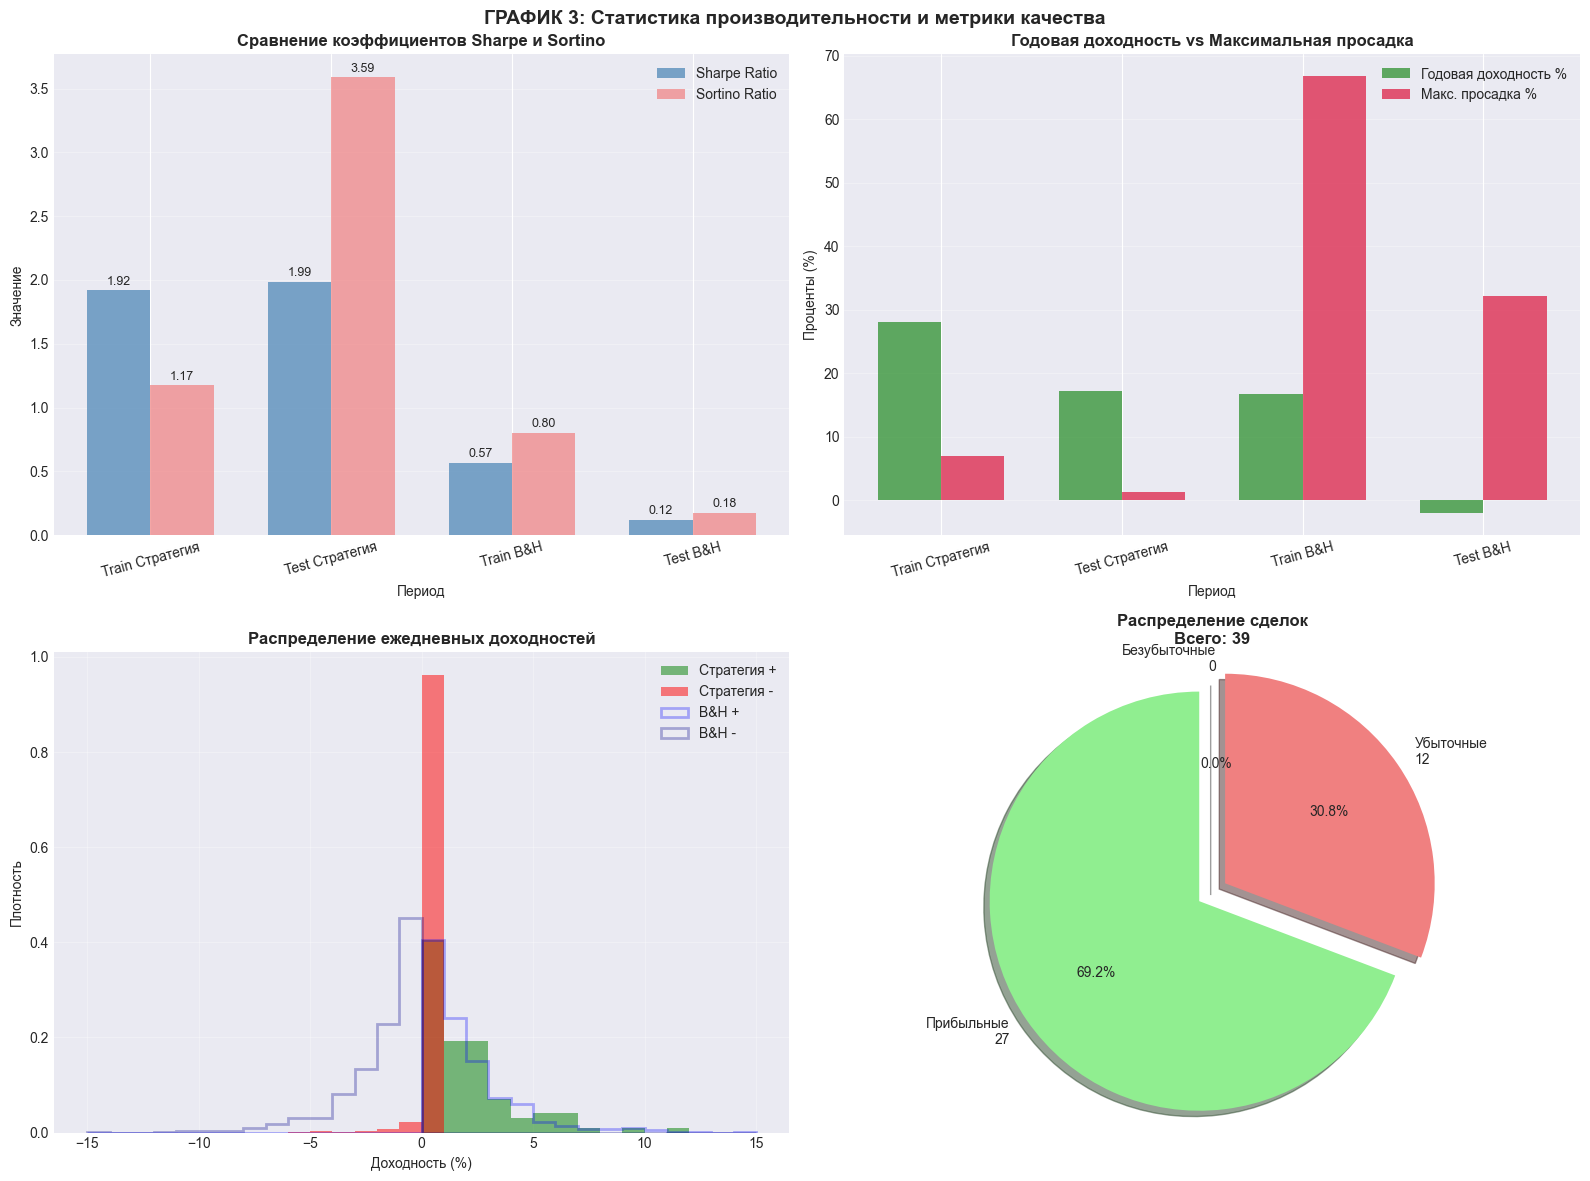


СТАТИСТИКА СДЕЛОК:
   Всего сделок: 39
   Прибыльных: 27 (69.2%)
   Убыточных: 12
   Средняя прибыль: 3.67%
   Максимальная прибыль: 21.20%
   Максимальный убыток: -6.95%


In [7]:
# Расчет метрик
metrics_calculator = PerformanceMetrics()

train_metrics = metrics_calculator.calculate_all_metrics(results["train"]["Strategy_Return"])
test_metrics = metrics_calculator.calculate_all_metrics(results["test"]["Strategy_Return"])
train_bh_metrics = metrics_calculator.calculate_all_metrics(results["train"]["BuyHold_Return"])
test_bh_metrics = metrics_calculator.calculate_all_metrics(results["test"]["BuyHold_Return"])

# Анализ сделок
trade_analysis = metrics_calculator.analyze_trades(trades["full"])

# Визуализация
visualizer = StrategyVisualizer()
fig = visualizer.plot_performance_metrics(
    results["full"],
    trades["full"],
    train_metrics,
    test_metrics,
    train_bh_metrics,
    test_bh_metrics,
)
plt.show()

# Детальная статистика сделок
if trade_analysis:
    print("\nСТАТИСТИКА СДЕЛОК:")
    print(f"   Всего сделок: {trade_analysis['total_trades']}")
    print(
        f"   Прибыльных: {trade_analysis['profitable_trades']} "
        f"({trade_analysis['win_rate']:.1f}%)"
    )
    print(f"   Убыточных: {trade_analysis['losing_trades']}")
    print(f"   Средняя прибыль: {trade_analysis['avg_profit']:.2f}%")
    print(f"   Максимальная прибыль: {trade_analysis['max_profit']:.2f}%")
    print(f"   Максимальный убыток: {trade_analysis['max_loss']:.2f}%")

## Выводы

В работе представлена и протестирована торговая система, основанная на комбинации PSAR, фракталов и ATR. Полученные результаты демонстрируют, что предложенная комбинация индикаторов может быть эффективна для торговли на высоковолатильных рынках, таких как криптовалютный. Однако для практического применения необходима дополнительная проверка устойчивости системы на более длительных периодах и с учетом транзакционных издержек.

Хотя тестирование на независимом периоде снижает риск переобучения, параметры были оптимизированы на конкретном историческом периоде.
В расчетах не учитывались комиссии, которые могут существенно повлиять на результаты при частых сделках.
Система не использует short-позиции, что ограничивает ее применение на медвежьих рынках.

Перспективные направления для дальнейших исследований включают:
- Расширение системы для работы с short-позициями
- Тестирование на других классах активов (акции, валюты, товары)
- Включение машинного обучения для динамической адаптации параметров
- Учет транзакционных издержек и slippage

Основной код системы доступен на GitHub: https://github.com/lyaminartemiy/hse-crypto-strategy-psar-fractals.